## Dropout

In this post I want to look at the regularization technique called *dropout*. This technique was introduced by Srivastava, *et al.* in the paper [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) in 2014. As stated by the authors, they created dropout to address the ubiquitous problem of overfitting:

> Deep neural networks contain multiple non-linear hidden layers and this makes them very expressive models that can learn very complicated relationships between their inputs and outputs. With limited training data, however, many of these complicated relationships will be the result of sampling noise, so they will exist in the training set but not in real test data even if it is drawn from the same distribution. This leads to overfitting...

They also note that the best solution to this problem would be, for a given model, to average the predictions from an infinite number of networks where each network has one combination of all the possible values for the weights and biases. Even if it were possible, this approach would be impractical due to time and computation constraints. To approximate this ideal average, the authors showed that a scaling procedure included with dropout was a good estimate. 

I will first look at the basic process of a forward pass in a network with dropout, then discuss the scaling procedure mentioned above, and end with a brief outline of how the backward pass is handled. 

### Basic process

The main idea behind dropout is that during the training process, for each new sample, some of the units in the network are turned off. And by turned off, it means they have an output of zero, and do not contribute to the gradient for weight updates. During test time, however, all units are active. 

To get a more concrete idea of how this works, I decided to focus on how this would look for a small network:

<center>
<img src="Dropout-1.jpg" width="600">
</center>

For each sample, before it goes through a forward pass calculation, a subnetwork is created by determining whether or not each unit in the original network will be active.  Whether to "keep" or "drop" a unit is determined by a Bernoulli random variable. 

To see how this can be done I first took a look at NumPy's binomial function: `random.binomial(n, p, size=None)`. When $n=1$ this is the same as a Bernoulli distribution. Now the confusing part: the `p` in this function refers to the probality of success (which is returned as a 1). T\However, to stay in line with the terms used in packages like [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [Keras](https://keras.io/api/layers/regularization_layers/dropout/), I want to represent the probability of keeping a unit (success) in terms of the probability of dropping a unit (failure): 

$$
p_{\text{keep}} = 1 - p_{\text{drop}}
$$

While a typical value for $p_{\text{drop}}$ is 0.5, which makes $p_{\text{keep}} = p_{\text{drop}}$, I need to keep the distinction in mind. 

Using $n=1$, $p_{\text{drop}} = 0.5$, I get:


In [1]:
import numpy as np

np.random.binomial(1, 1 - 0.5, size=(4, ))

array([1, 0, 1, 1], dtype=int32)

For my network, the index of the output corresponds to the unit we are talking about, with a 1 meaning keep the unit in the subnetwork, and a 0 meaning drop the unit from the subnetwork. If I did this for 3 samples, I may get 3 subnetworks like the following: 

<center>
<img src="Dropout-2.jpg" width="600">
</center>

To make it even clearer for myself, since a Bernoulli random variable takes on one of two outcomes, I think of this as follows: 
 - start with the original network
 - create a subnetwork for current training sample:
    - for each unit flip a fair coin (since $p=0.5$):
        - heads = keep
        - tails = drop
- do the forward pass using this subnetwork
- repeat for all training samples

Visually:

<center>
<img src="Dropout-3.jpg" width="700">
</center>

The next thing I wanted to look at was the distribution of dropped units across all the subnetworks. When doing this I noticed that my small example network is misleading in that it has a fairly high probability for all units to be dropped in a subnetwork, which would mean no subnetwork. This is not the case for networks that would be used in practice. The plots below show the results of two original networks with 4 units and 100 units, respectively, with the dropout recipe applied 1000 times for $p_{\text{drop}} = 0.5$.

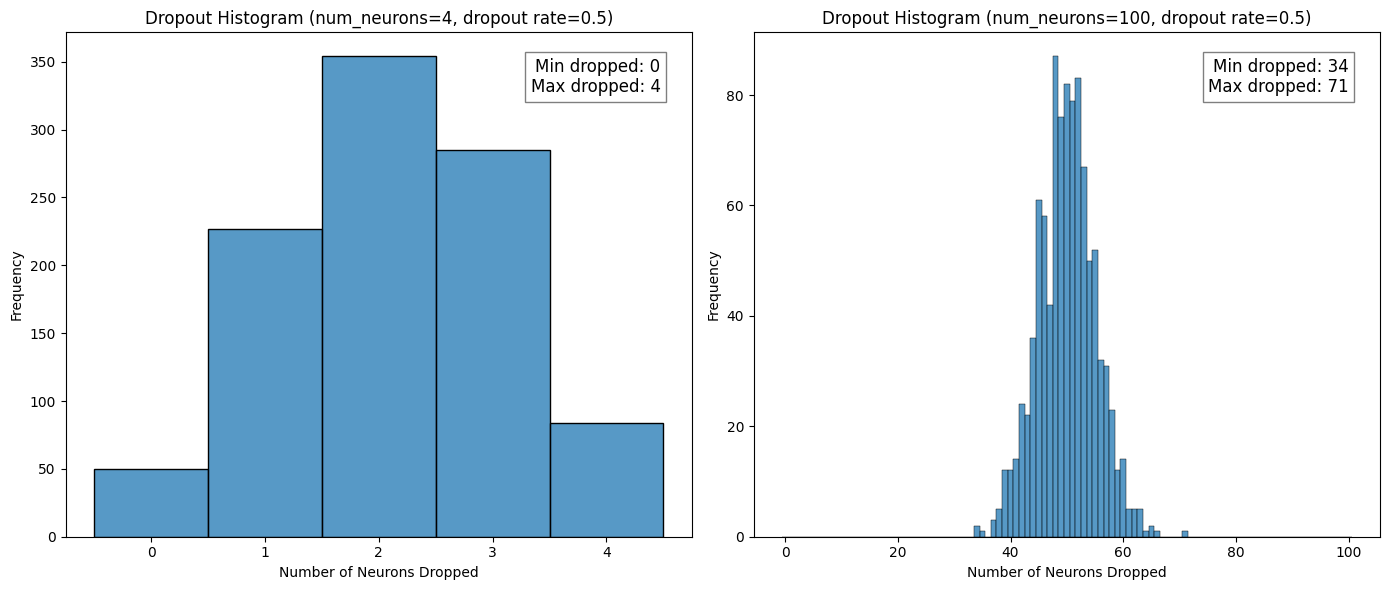

In [2]:
#| code-fold: true
import seaborn as sns
import matplotlib.pyplot as plt

def dropout_histogram(num_neurons1, num_neurons2, drop_rate, num_trials):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First plot
    dropped_neurons1 = []
    for _ in range(num_trials):
        neurons = np.random.binomial(1, 1-drop_rate, size=num_neurons1)  
        dropped_neurons1.append(np.sum(neurons == 0))  

    sns.histplot(dropped_neurons1, bins=np.arange(-0.5, num_neurons1 + 1.5, 1), kde=False, ax=axes[0])
    axes[0].set_xlabel("Number of Neurons Dropped")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"Dropout Histogram (num_neurons={num_neurons1}, dropout rate={drop_rate})")

    # Second plot
    dropped_neurons2 = []
    for _ in range(num_trials):
        neurons = np.random.binomial(1, 1-drop_rate, size=num_neurons2)  
        dropped_neurons2.append(np.sum(neurons == 0))  

    sns.histplot(dropped_neurons2, bins=np.arange(-0.5, num_neurons2 + 1.5, 1), kde=False, ax=axes[1])
    axes[1].set_xlabel("Number of Neurons Dropped")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Dropout Histogram (num_neurons={num_neurons2}, dropout rate={drop_rate})")

    # Add text noting the minimum and maximum number of dropped neurons
    min_dropped = min(dropped_neurons2)
    max_dropped = max(dropped_neurons2)
    textstr = f'Min dropped: {min_dropped}\nMax dropped: {max_dropped}'
    axes[1].text(0.95, 0.95, textstr, transform=axes[1].transAxes, fontsize=12,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

    min_dropped = min(dropped_neurons1)
    max_dropped = max(dropped_neurons1)
    textstr = f'Min dropped: {min_dropped}\nMax dropped: {max_dropped}'
    axes[0].text(0.95, 0.95, textstr, transform=axes[0].transAxes, fontsize=12,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()


dropout_histogram(num_neurons1=4, num_neurons2=100, drop_rate=0.5, num_trials=1000)

It is easier to see from the histograms that for more realistic numbers of units, the probability of all units being dropped is $p_{\text{drop}}^{100} = 7.889\times 10^{-31}$, which is essentially 0.

The last thing I want to address in this section is how this process looks in code. Using PyTorch on my example network with 5 samples:

In [3]:
import torch

torch.manual_seed(12)

# without dropout
input1 = torch.ones(5, 3)
dense_layer1 = torch.nn.Linear(3, 4)
output1 = dense_layer1(input1)

# with dropout
dense_layer2 = dense_layer1(input1)
output2 = torch.nn.Dropout(p=0.5)(dense_layer2)

print(f"Without dropout:\n{output1.detach()},\n\nWith dropout:\n{output2.detach()}")

Without dropout:
tensor([[-0.3069, -0.2832,  0.1922, -0.2970],
        [-0.3069, -0.2832,  0.1922, -0.2970],
        [-0.3069, -0.2832,  0.1922, -0.2970],
        [-0.3069, -0.2832,  0.1922, -0.2970],
        [-0.3069, -0.2832,  0.1922, -0.2970]]),

With dropout:
tensor([[-0.0000, -0.5664,  0.3843, -0.0000],
        [-0.6139, -0.0000,  0.0000, -0.0000],
        [-0.0000, -0.5664,  0.0000, -0.0000],
        [-0.6139, -0.5664,  0.3843, -0.5941],
        [-0.6139, -0.0000,  0.3843, -0.0000]])


I can see that the output without and with dropout is as expected. In the former case, given that all samples have the same values, I would expect each unit's activation output to be the same value for each sample, which is indeed what I see. For the latter case, I would expect the same activation outputs but that some of them have been zeroed out which is the case; if the seed value is removed, rerunning the code will show the randomness of which units are dropped. The fact that the same activations are not output when dropout was introduced leads me to the next topic: activation scaling. 

But before moving I want to check if this dropout layer gives me the same statistics as the Bernoulli function. The plot below shows that this does seem to be the case

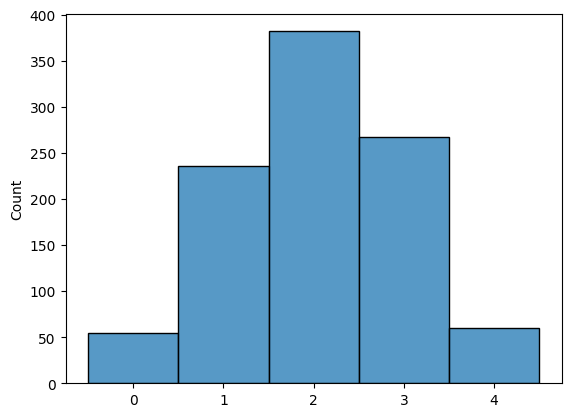

In [4]:
counts = []

for _ in range(1000):
    m = torch.nn.Dropout(p=0.5)
    input = torch.ones(1, 4)
    output = m(input)
    cnt = (output==0).sum()
    counts.append(cnt.item())

sns.histplot(data=counts, bins=np.arange(-0.5, 4 + 1.5, 1))
plt.show()

### Scaling

If I inspect the torch output above for my network with and without dropout, I notice that the activations with dropout are two times the values without dropout. This is not by accident. In fact, the relationship between the two is given by:

$$
a_{\rm{drop}} = \frac{1}{1 - p_{\rm{drop}}}\times a_{\rm{no\,drop}}
$$
This scaling is done at the same time as the dropout mask is applied to the activations of the network layer. In the image below the * operation is element-wise multiplication.
<center>
<img src="Dropout-6.jpg" width="600">
</center>

To do a true averaging process at test time, one would need to make predictions for each test sample across all subnetworks and then average them. With $2^n$ possible subnetworks, this is not possible. Instead, the authors of the original paper showed that a more practical scaling approach gives a good approximation to the true average (see their Fig. 11). In the paper they showed how scaling the weights of a dropout layer was practically equivalent to doing the proper averaging; that is, at test time, replace all weights, $w$, of the layer with dropout with scaled weights, $p_{\rm{keep}}w$. 

In practice, and how it is implemented in deep learning frameworks like PyTorch and Keras is what is sometimes called *inverted dropout*, where the activations are scaled, as noted above. The advantage of inverted dropout is that the network layers remain unchanged during both training and testing. The only thing that changes is whether or not dropout is applied; and this can be controlled by a boolean argument `training` whenever the layer is called. 

To understand this scaling concept, I looked at the [expected value](https://en.wikipedia.org/wiki/Expected_value) for the activation of a unit in a layer. As a recap, the expected value of a discrete random variable is:

$$
E[X] = \sum_{i=0}^{1} x_i p(X=x_i),
$$
where $x_i$ is one of the possible values that $X$ can have and $p_i$ is the associated probability of getting that value. To make it clearer, the expected value for a six-sided die roll is:

$$
\begin{align*}
E[\rm{roll}] &= 1\times\frac{1}{6} + 2\times\frac{1}{6} + 3\times\frac{1}{6} + 4\times\frac{1}{6} + 5\times\frac{1}{6} + 6\times\frac{1}{6} \\
&= \frac{1+2+3+4+5+6}{6} \\
&= 3.5\\
\end{align*}
$$
This is interpreted as the mean of the outcomes as the number of die rolls approaches infinity. 



Applying this principle to a network at test time, the expected activation value of a unit is:
$$
\begin{align*}
E[A] &= \sum_{i=0}^{1} a_i p(A=a_i) \\
&= 0\times p_{\text{drop}} + a\times(1 - p_{\text{drop}}) \\
&= a\times(1 - 0) \\
&= a
\end{align*}
$$
where $a$ is the activation. This is true because $p_{\text{drop}} = 0$ since no units are dropped during test time. During training, however, the expected value without scaling would be:

$$
\begin{align*}
E[A] &= \sum_{i=0}^{1} a_i p(A=a_i) \\
&= 0\times p_{\text{drop}} + a\times(1 - p_{\text{drop}}) \\
&= a\times(1 - p_{\text{drop}}) \\
&< a
\end{align*}
$$

If, however, a scaling of $ a' = a / (1 - p_{\text{drop}})$ is carried out then the expected value would be:

$$
\begin{align*}
E[A] &= \sum_{i=0}^{1} a_i p(A=a_i) \\
&= 0\times p_{\text{drop}} + a'\times(1 - p_{\text{drop}}) \\
&= 0\times p_{\text{drop}} + \frac{a}{(1 - p_{\text{drop}})}\times(1 - p_{\text{drop}}) \\
& = a
\end{align*}
$$






This part has not yet clicked with me on a fundamental level. For now, I also like to think of it in the following way, using an even smaller example network:

<center>
<img src="Dropout-8.jpg" width="700">
</center>

As the image shows, for this network I can have only 4 different subnetworks, each occuring with the same probability. If I do an average of a test samples predictions over the subnetworks at test time, without scaling, this is not equivalent to using the full network (no units) dropped. To achieve equivalence, we can either scale the weights or the activations. 

### Gradients

The last topic I want to touch on is how the gradients are handled during training given that sometimes units are on and sometimes units are off. For my original example network, if I consider a mini-batch of 3 samples we get the following:

<center>
<img src="Dropout-4.jpg" width="700">
</center>

Assuming mini-batch gradient descent, the units that are dropped have 0 gradient and the units that are kept have an associated gradient. For each unit, the gradients are accumulated until the end of the mini-batch, then averaged. The average is then used for the weight updates. 

So, in this example, considering only the weights connecting $f_1$ to each unit, and referring to them as $w_1$, $w_2$, $w_3$, and $w_4$, each weight would be updated as follows:

$$
\begin{align*}
w_{1} &\leftarrow w_{1} - \rm{learning \, rate} \times \frac{1}{3}\left[ \left(\frac{\partial L}{\partial w_{1}}\right)_{\rm{subnet \,1}} + \left(\frac{\partial L}{\partial w_{1}}\right)_{\rm{subnet \,2}} + \left(\frac{\partial L}{\partial w_{1}}\right)_{\rm{subnet \,3}} \right] \\
&= w_{1} - \rm{learning \, rate} \times \frac{1}{3}\left[ 0 + 0 + \left(\frac{\partial L}{\partial w_{1}}\right)_{\rm{subnet \,3}} \right] \\
\\
w_{2} &\leftarrow w_{2} - \rm{learning \, rate} \times \frac{1}{3}\left[ \left(\frac{\partial L}{\partial w_{2}}\right)_{\rm{subnet \,1}} + \left(\frac{\partial L}{\partial w_{2}}\right)_{\rm{subnet \,2}} + \left(\frac{\partial L}{\partial w_{2}}\right)_{\rm{subnet \,3}} \right] \\
&= w_{2} - \rm{learning \, rate} \times \frac{1}{3}\left[\left(\frac{\partial L}{\partial w_{2}}\right)_{\rm{subnet \,1}} +0 + 0 \right] \\
\\
w_{3} &\leftarrow w_{3} - \rm{learning \, rate} \times \frac{1}{3}\left[ \left(\frac{\partial L}{\partial w_{3}}\right)_{\rm{subnet \,1}} + \left(\frac{\partial L}{\partial w_{3}}\right)_{\rm{subnet \,2}} + \left(\frac{\partial L}{\partial w_{3}}\right)_{\rm{subnet \,3}} \right] \\
&= w_{3} - \rm{learning \, rate} \times \frac{1}{3}\left[ 0 + \left(\frac{\partial L}{\partial w_{3}}\right)_{\rm{subnet \,2}} + \left(\frac{\partial L}{\partial w_{3}}\right)_{\rm{subnet \,3}} \right] \\
\\
w_{4} &\leftarrow w_{4} - \rm{learning \, rate} \times \frac{1}{3}\left[ \left(\frac{\partial L}{\partial w_{4}}\right)_{\rm{subnet \,1}} + \left(\frac{\partial L}{\partial w_{4}}\right)_{\rm{subnet \,2}} + \left(\frac{\partial L}{\partial w_{4}}\right)_{\rm{subnet \,3}} \right] \\
&= w_{4} - \rm{learning \, rate} \times \frac{1}{3}\left[ \left(\frac{\partial L}{\partial w_{4}}\right)_{\rm{subnet \,1}} + 0 + \left(\frac{\partial L}{\partial w_{4}}\right)_{\rm{subnet \,3}} \right] \\
\\

\end{align*}
$$

Of course, one could go deeper into dropout, or expand to cover its use in convolutional networks; But, at least for now, that is it for this post. 